<a href="https://colab.research.google.com/github/wksmirnowa/machinelearning_homeworks/blob/master/Smirnova_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подготовлено на базе соревнования "[Jigsaw Multilingual Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/submit)"

## Импорты

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/My Drive/ml_exam/jigsaw-toxic-comment-train.csv.zip'

Archive:  /content/drive/My Drive/ml_exam/jigsaw-toxic-comment-train.csv.zip
  inflating: jigsaw-toxic-comment-train.csv  


In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 3.4MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance

import string
from string import punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from numpy.random import seed
seed(0)
from tensorflow.random import set_seed
set_seed(0)

## Предобработка

In [ ]:
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('english'))

def normalize(text):

  text = text.lower().strip(punct).split()
  words = []

  for word, tag in pos_tag(text):
    lemtag = tag[0].lower()
    lemtag = lemtag if lemtag in ['a', 'r', 'n', 'v'] else None

    if word not in stops:
      if not lemtag:
        words.append(word)
      else:
        lemma = lem.lemmatize(word, lemtag)
        words.append(lemma)

  return " ".join(words)

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split() if word and word not in stops]
    words = [word for word in words if word]

    return words

In [ ]:
toxic = pd.read_csv('/content/jigsaw-toxic-comment-train.csv')

In [ ]:
toxic.dropna()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [ ]:
toxic.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
sample = toxic.sample(frac=0.1)

In [ ]:
%%time
sample['normalized'] = sample['comment_text'].apply(lambda x: normalize(x))

CPU times: user 1min 10s, sys: 429 ms, total: 1min 11s
Wall time: 1min 11s


In [ ]:
sample.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normalized
57400,997db026afacc8b3,"Also, it is MY talk page, not YOURS. What sens...",0,0,0,0,0,0,"also, talk page, yours. sense make make three ..."
82445,dc98afa66db1aaff,"Actually, the whole fact that it's an encyclop...",0,0,0,0,0,0,"actually, whole fact encyclopedia internet any..."
104821,30cff5d6c74a9d42,I suggest that you WP:AGF here.,0,0,0,0,0,0,suggest wp:agf
177575,474da499938d0f0c,""" \n\n :Metro isn't synonymous w central tho, ...",0,0,0,0,0,0,":metro synonymous w central tho, unless know c..."
6783,1214b04198c00c49,If you want to make your mark on Wikipedia by ...,0,0,0,0,0,0,want make mark wikipedia add entry conservativ...
81438,d9d7e074a008478f,Private Eye \n\nWhat are the reliability issue...,0,0,0,0,0,0,private eye reliability issues? major investig...
115985,6c2ade6750bae1db,Hey 2help the article on Auburndale High Schoo...,0,0,0,0,0,0,hey 2help article auburndale high school. chan...
87362,e9be7c78eab6d0d0,"""\n\n My RFA \n\nThank you, Ral315, for having...",0,0,0,0,0,0,"rfa thank you, ral315, trust vote """"support"""" ..."
77582,cfdbd04462854f0f,Vandalism on the WeatherStar 4000 article \n\n...,0,0,0,0,0,0,vandalism weatherstar 4000 article repeat vand...
156551,d01cec5f351ed1d3,"""\nOh? Yet you chose to reply to this post ra...",0,0,0,0,0,0,oh? yet choose reply post rather simply delete...


## 1 строка: Анализ данных 

*Описательный анализ данных с привязкой к целевой переменной (toxic) и 2 другим дополнительным колонкам (как минимум 5 статистик на каждую группу)*

---
или
*Анализ всех дополнительных колонок тональности (как проявляется тот или иной тип токсичности, как в данных это представлено, какие есть пограничные случаи*

---

Посмотрим общую информацию о колонках и убедимся, что нет полностью нулевых или пустых колонок с бинарными значениями.

In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22355 entries, 57400 to 173746
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             22355 non-null  object
 1   comment_text   22355 non-null  object
 2   toxic          22355 non-null  int64 
 3   severe_toxic   22355 non-null  int64 
 4   obscene        22355 non-null  int64 
 5   threat         22355 non-null  int64 
 6   insult         22355 non-null  int64 
 7   identity_hate  22355 non-null  int64 
 8   normalized     22355 non-null  object
dtypes: int64(6), object(3)
memory usage: 1.7+ MB


In [ ]:
sample.toxic.unique()

array([0, 1])

In [ ]:
sample.severe_toxic.unique()

array([0, 1])

In [ ]:
sample.obscene.unique()

array([0, 1])

In [ ]:
sample.threat.unique()

array([0, 1])

In [ ]:
sample.insult.unique()

array([0, 1])

In [ ]:
sample.identity_hate.unique()

array([0, 1])

Во всех колонках с бинарными значениями есть как нули, так и единицы.

Посчитаем, сколько в сэмпле текстов и сколько среди них уникальных.

In [ ]:
#всего текстов
len(sample.toxic)

22355

In [ ]:
#как оказалось, не все тексты в данных уникальные, в данных есть дубликаты
len(sample.normalized.unique())

22333

In [ ]:
#число токсичных (1) и нетоксичных (0) текстов
sample.toxic.value_counts()

0    20209
1     2146
Name: toxic, dtype: int64

Посмотрим примеры токсичных и нетоксичных текстов

In [ ]:
grouped_by_toxic = sample.groupby('toxic')
grouped_by_toxic.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normalized
57400,997db026afacc8b3,"Also, it is MY talk page, not YOURS. What sens...",0,0,0,0,0,0,"also, talk page, yours. sense make make three ..."
82445,dc98afa66db1aaff,"Actually, the whole fact that it's an encyclop...",0,0,0,0,0,0,"actually, whole fact encyclopedia internet any..."
104821,30cff5d6c74a9d42,I suggest that you WP:AGF here.,0,0,0,0,0,0,suggest wp:agf
177575,474da499938d0f0c,""" \n\n :Metro isn't synonymous w central tho, ...",0,0,0,0,0,0,":metro synonymous w central tho, unless know c..."
6783,1214b04198c00c49,If you want to make your mark on Wikipedia by ...,0,0,0,0,0,0,want make mark wikipedia add entry conservativ...
2620,0700ee9d51b55d33,William S Saturn is a sockpuppet \n\nHey dickw...,1,0,1,0,1,0,"william saturn sockpuppet hey dickweed saturn,..."
186005,694aa815ed55a203,""" \n Its funny you say that because I consider...",1,0,0,0,1,0,"funny say consider insinuation lack """"common s..."
177290,46433746ae83ddfd,My Dad reckons it's because they tried to brea...,1,0,0,0,0,0,"dad reckons try break america, fucked off, fai..."
189484,7745d70dfed611c8,Naconkantari is a Gay Japanese Freak,1,0,0,0,1,1,naconkantari gay japanese freak
109389,490b2fbf5bf20741,Go to hell \n\nFuck you,1,0,1,0,1,0,go hell fuck


In [ ]:
#примеры токсичных текстов
sample_toxic = sample[sample.toxic == 1]
for text in sample_toxic.comment_text.head(10):
  print(text)

William S Saturn is a sockpuppet 

Hey dickweed Saturn, remember me?  You dumb fat bitch
" 
 Its funny you say that because I consider your insinuation that I lack ""common sense"" to be a personal attack. But hey, what do I Know? According to you Im some dumb sockpuppet right?"
My Dad reckons it's because they tried to break America, so the fucked off, failed and by the time they came back, no one cared here.
Naconkantari is a Gay Japanese Freak
Go to hell 

Fuck you
Blah blah blah blah. Stay off my talk page. Dont look at my talk page. Dont respond to my talk page or to others who comment on my talk page. Stay on your side of Wikipedia and off mine. Blaaaaaaaaaaaaaaaaah.
You're a dishonest asshole that will never touch a girl until you move out of your parent's basement
* Mwahahaha!  The fools!  Our dastardly plan worked!  Now you can make my army of socks admins, and together we can take over the... oh, wait.  It isn't closed yet?  Nevermind. (congrats a few minutes early)
sex fucks

In [ ]:
#примеры нетоксичных текстов
sample_toxic = sample[sample.toxic == 0]
for text in sample_toxic.comment_text.head(10):
  print(text)

Also, it is MY talk page, not YOURS. What sense does it make to make THREE edits on my talk page without MY permission? Would you like it if someone did it to YOU? Learn some manners first.
Actually, the whole fact that it's an encyclopedia on the internet that anyone can edit (therefore has questionable reliability) gives Wikipedia a bad name. But enough. When I said 'boring' I was using it as a derogatory term in general. Although he is boring, I was attacking him because I don't buy his theories because I think he presents them in an unintelligent light. I didn't take it very seriously because I don't think it was written seriously (although he was thorough, I'll give him that). And the first person who posted here, please sign your name, not to mention read all the stuff I've written in the homosexuality section.
Anyway, I think the treasure trove part, unless it is proven to be false, works fine because that is the current theory. Any objections?
I suggest that you WP:AGF here.
" 

In [ ]:
#примеры сильно токсичных текстов
sample_severe_toxic = sample[sample.severe_toxic == 1]
for text in sample_severe_toxic.comment_text.head(10):
  print(text)

sex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fuck

Узнаем, каково отношение разных типов текстов ко всему сэмплу.

In [ ]:
toxic_pc = (len(sample[sample.toxic == 1])*100)/len(sample.toxic)
print(f'Процент токсичных текстов в корпусе ≈ {toxic_pc}%')

Процент токсичных текстов в корпусе ≈ 9.59964213822411%


In [ ]:
severe_toxic_pc = (len(sample[sample.severe_toxic == 1])*100)/len(sample.toxic)
print(f'Процент очень токсичных текстов в корпусе ≈ {severe_toxic_pc}%')

Процент очень токсичных текстов в корпусе ≈ 0.8409751733392977%


In [ ]:
obscene_pc = (len(sample[sample.obscene == 1])*100)/len(sample.toxic)
print(f'Процент текстов с обсценной лексикой ≈ {obscene_pc}%')

Процент текстов с обсценной лексикой ≈ 5.443972265712369%


In [ ]:
threat_pc = (len(sample[sample.threat == 1])*100)/len(sample.toxic)
print(f'Процент текстов с угрозами ≈ {threat_pc}%')

Процент текстов с угрозами ≈ 0.29076269290986356%


In [ ]:
insult_pc = (len(sample[sample.insult == 1])*100)/len(sample.toxic)
print(f'Процент текстов с оскорблениями ≈ {insult_pc}%')

Процент текстов с оскорблениями ≈ 4.9921717736524265%


In [ ]:
identity_hate_pc = (len(sample[sample.identity_hate == 1])*100)/len(sample.toxic)
print(f'Процент текстов с ненавистью на почве идентичности ≈ {identity_hate_pc}%')

Процент текстов с ненавистью на почве идентичности ≈ 0.876761350928204%


Число текстов, которые являются одновременно токсичными и очень токсичными, что логично, одинаково.

In [ ]:
sample_severe_toxic = sample[sample.severe_toxic==1]
sample_severe_toxic_toxic = sample_severe_toxic[sample_severe_toxic.toxic==1]
len(sample_severe_toxic_toxic)

188

А сколько у нас текстов, являющихся токсичными, но не слишком?

In [ ]:
sample_severe_toxic = sample[sample.severe_toxic==0]
sample_severe_toxic_toxic = sample_severe_toxic[sample_severe_toxic.toxic==1]
len(sample_severe_toxic_toxic)

1958

Посмотрим такие же статистики для обсценной лексики: сколько у нас токсичных текстов без нее?

In [ ]:
sample_obscene = sample[sample.obscene==0]
sample_obscene_toxic = sample_obscene[sample_obscene.toxic==1]
len(sample_obscene_toxic)

985

И с ней.

In [ ]:
sample_obscene = sample[sample.obscene==1]
sample_obscene_toxic = sample_obscene[sample_obscene.toxic==1]
len(sample_obscene_toxic)

1161

Проверим то же самое для текстов с угрозами, оскорблениями и ненавистью на почве идентичности.

In [ ]:
#токсичные тексты с угрозами
sample_threat = sample[sample.threat==1]
sample_threat_toxic = sample_threat[sample_threat.toxic==1]
len(sample_threat_toxic)

62

In [ ]:
#токсичные тексты без угроз
sample_nothreat = sample[sample.threat==0]
sample_nothreat_toxic = sample_nothreat[sample_nothreat.toxic==1]
len(sample_nothreat_toxic)

2084

In [ ]:
#токсичные тексты с оскорблениями
sample_insult = sample[sample.insult==1]
sample_insult_toxic = sample_insult[sample_insult.toxic==1]
len(sample_insult_toxic)

1056

In [ ]:
#токсичные тексты без оскорблений
sample_insult = sample[sample.insult==0]
sample_insult_toxic = sample_insult[sample_insult.toxic==1]
len(sample_insult_toxic)

1090

In [ ]:
#токсичные тексты с ненавистью на почве идентичности
sample_identity_hate = sample[sample.identity_hate==1]
sample_identity_hate_toxic = sample_identity_hate[sample_identity_hate.toxic==1]
len(sample_identity_hate_toxic)

182

In [ ]:
#токсичные тексты без ненависти на почве идентичности
sample_identity_hate = sample[sample.identity_hate==0]
sample_identity_hate_toxic = sample_identity_hate[sample_identity_hate.toxic==1]
len(sample_identity_hate_toxic)

1964

Посмотрим примеры текстов с обсценной лексикой, угрозами, оскорблениями и ненавистью.

In [ ]:
#примеры текстов с обсценной лексикой
sample_obscene = sample[sample.obscene == 1]
for text in sample_obscene.comment_text.head(5):
  print(text)

William S Saturn is a sockpuppet 

Hey dickweed Saturn, remember me?  You dumb fat bitch
Go to hell 

Fuck you
You're a dishonest asshole that will never touch a girl until you move out of your parent's basement
sex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex fucksex 

In [ ]:
#примеры текстов с угрозами
sample_threat = sample[sample.threat == 1]
for text in sample_threat.comment_text.head(5):
  print(text)

Hope he dies 

Now this Atheist filth's wife has gone, he should follow soon and give us all a rest from him Paedophillic behaviour.
:You know what I'd like to award you? A punch to the jaw!
If you think SOAD is nu-metal.... 

You are a fucking goddamn retard and you should fucking die in a fucking fire.
Kill Feldspar 

Feldspar is a blathering idiot that should be publicly executed for his attempted use of force in place of honest debate to reconcile differences in opinion. Forever small minded psuedointellectuals such as he hide behind anti violence laws and become masters at manipulation, abuse of rules, and all manner of passive aggressive means to force others to accept their views. Antiviolence laws are obviously not designed to protect such behavior, rather they are designed to encourage open mindedness towards others viewpoints with the understanding that noone wins when people use force back and forth to overcome each others' opinions.
If you fuck with us again we will bash yo

In [ ]:
#примеры текстов с оскорблениями
sample_insult = sample[sample.insult == 1]
for text in sample_insult.comment_text.head(5):
  print(text)

William S Saturn is a sockpuppet 

Hey dickweed Saturn, remember me?  You dumb fat bitch
" 
 Its funny you say that because I consider your insinuation that I lack ""common sense"" to be a personal attack. But hey, what do I Know? According to you Im some dumb sockpuppet right?"
Naconkantari is a Gay Japanese Freak
Go to hell 

Fuck you
You're a dishonest asshole that will never touch a girl until you move out of your parent's basement


In [ ]:
#примеры текстов с ненавистью
sample_identity_hate = sample[sample.identity_hate == 1]
for text in sample_identity_hate.comment_text.head(5):
  print(text)

Naconkantari is a Gay Japanese Freak
YOUR VERY DEEPLY OFFENDED! man you sound like a blow-jobbin' old lady. In fact you are a homosexual blow-jobbin' old lady!
"

Too funny

corey suggests a famous people section from moline or historical signicance section, but that is just too funny.  These guys will probably tell you about some confederate hero or plantation owner or other backwood gomer.  ""What do you call a person from Moline who has all their teeth?  An obvious no-good no-account yankee LIAR who just rode in.""  Hmmm... not a very funny joke, but then again, racism isn't funny either, and this page is completely racist.  Backward, ignorant, hillbilly, hee-haw, and racist."
Fucking niggers thanks for wasting my time here,I'll just go back to vandalizing this shithole
sarah palin is an ass kissing mother fucking loser with a melon in her hair. she sucks eggs that are from her brain-yuck stupid!- she is a bitch there i said it she is a sucker with a big bitch thing and a bitchy att

Сколько у нас значений в остальных колонках?

In [ ]:
sample.severe_toxic.value_counts()

0    22167
1      188
Name: severe_toxic, dtype: int64

In [ ]:
sample.obscene.value_counts()

0    21138
1     1217
Name: obscene, dtype: int64

In [ ]:
sample.threat.value_counts()

0    22290
1       65
Name: threat, dtype: int64

In [ ]:
sample.insult.value_counts()

0    21239
1     1116
Name: insult, dtype: int64

In [ ]:
sample.identity_hate.value_counts()

0    22159
1      196
Name: identity_hate, dtype: int64

Посмотрим на слова в нормализованном корпусе комментариев: сколько их всего, какие из них самые частотные для разных типов токсичности.

In [ ]:
vocab = Counter()
for text in sample.normalized:
    vocab.update(tokenize(text))

CPU times: user 581 ms, sys: 6.99 ms, total: 588 ms
Wall time: 590 ms


In [ ]:
#самые частотные слова
vocab.most_common(20)

[('article', 9234),
 ('page', 7003),
 ('wikipedia', 4445),
 ('use', 4179),
 ('would', 4131),
 ('make', 4098),
 ('one', 4013),
 ('talk', 4010),
 ('please', 3907),
 ('like', 3862),
 ('think', 3508),
 ('edit', 3505),
 ('see', 3388),
 ('know', 3310),
 ('say', 3173),
 ('go', 3064),
 ('get', 3046),
 ('also', 2819),
 ('source', 2634),
 ("i'm", 2574)]

In [ ]:
#общее количество слов
sum(vocab.values())

809455

In [ ]:
#число уникальных токенов
len(vocab.keys())

73286

In [ ]:
sample_toxic = sample[sample.toxic==1]

toxic_vocab = Counter()
for text in sample_toxic.normalized:
    toxic_vocab.update(tokenize(text))

In [ ]:
#самые частотные слова для токсичных текстов
toxic_vocab.most_common(20)

[('fuck', 2024),
 ('suck', 1073),
 ('ball', 852),
 ('u', 676),
 ('go', 660),
 ('fucksex', 624),
 ('moron', 576),
 ('hi', 572),
 ('gay', 559),
 ('like', 522),
 ('you', 513),
 ('know', 508),
 ('cock', 506),
 ('kill', 472),
 ('bullshit', 464),
 ('bitch', 440),
 ('get', 436),
 ('nigger', 433),
 ('cunt', 408),
 ('page', 375)]

In [ ]:
sample_severe_toxic = sample[sample.severe_toxic==1]

severe_toxic_vocab = Counter()
for text in sample_severe_toxic.normalized:
    severe_toxic_vocab.update(tokenize(text))

CPU times: user 13.6 ms, sys: 989 µs, total: 14.6 ms
Wall time: 18.3 ms


In [ ]:
#самые частотные слова для самых токсичных
severe_toxic_vocab.most_common(20)

[('fuck', 1039),
 ('suck', 784),
 ('fucksex', 624),
 ('cock', 475),
 ('u', 378),
 ('cunt', 373),
 ('go', 367),
 ('damn', 314),
 ('gay', 306),
 ('yourself', 294),
 ('bitch', 291),
 ('criminalwar', 279),
 ('bunksteve', 278),
 ('fack', 223),
 ('ancestryfuck-off-jewish', 207),
 ('nigger', 183),
 ('ballz', 171),
 ('die', 164),
 ('kill', 163),
 ('must', 157)]

In [ ]:
sample_obscene = sample[sample.obscene==1]

obscene_vocab = Counter()
for text in sample_obscene.normalized:
    obscene_vocab.update(tokenize(text))

In [ ]:
#самая частотная обсценная лексика
obscene_vocab.most_common(20)

[('fuck', 2002),
 ('suck', 1047),
 ('fucksex', 624),
 ('u', 622),
 ('cock', 504),
 ('go', 474),
 ('bullshit', 451),
 ('bitch', 431),
 ('cunt', 407),
 ('you', 404),
 ('know', 352),
 ('damn', 337),
 ('yourself', 308),
 ('get', 273),
 ('like', 234),
 ('dick', 231),
 ('page', 224),
 ('shit', 223),
 ('fack', 223),
 ('fucking', 220)]

In [ ]:
sample_insult = sample[sample.insult==1]

insult_vocab = Counter()
for text in sample_insult.normalized:
    insult_vocab.update(tokenize(text))

In [ ]:
#самые частотные слова для оскорблений
insult_vocab.most_common(20)

[('fuck', 1663),
 ('suck', 1023),
 ('u', 624),
 ('hi', 567),
 ('moron', 565),
 ('go', 528),
 ('cock', 497),
 ('nigger', 427),
 ('bitch', 417),
 ('cunt', 401),
 ('you', 396),
 ('gay', 368),
 ('know', 332),
 ('damn', 330),
 ('yourself', 307),
 ('bunksteve', 278),
 ('get', 267),
 ('like', 229),
 ('tommy2010', 227),
 ('page', 219)]

In [ ]:
sample_identity_hate = sample[sample.identity_hate==1]

identity_hate_vocab = Counter()
for text in sample_identity_hate.normalized:
    identity_hate_vocab.update(tokenize(text))

In [ ]:
#слова из текстов с ненавистью на почве идентичности
identity_hate_vocab.most_common(20)

[('gay', 456),
 ('nigger', 429),
 ('bunksteve', 278),
 ('tommy2010', 227),
 ('ancestryfuck-off-jewish', 207),
 ('suck', 195),
 ('spanish', 181),
 ('centraliststupid', 179),
 ('ballz', 171),
 ('fuck', 110),
 ('fucking', 105),
 ('cody', 93),
 ('utc', 93),
 ('get', 82),
 ('stupid', 77),
 ('u', 70),
 ('homo', 70),
 ('lolololol!!!!!!!!!!!!!!!!!!!naconkantari', 64),
 ('like', 56),
 ('couriano', 56)]

Однотипных слов в целом довольно много во всех текстах. Совсем новые слова попадаются в текстах с ненавистью на почве идентичности.

Посмотрим на корреляцию различных видов токсичности.

In [ ]:
sample.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.282607,0.698847,0.157253,0.661598,0.265805
severe_toxic,0.282607,1.000000,0.362216,0.095101,0.336525,0.243559
obscene,0.698847,0.362216,1.000000,0.133512,0.734430,0.275637
threat,0.157253,0.095101,0.133512,1.000000,0.136396,0.084038
insult,0.661598,0.336525,0.734430,0.136396,1.000000,0.341985
identity_hate,0.265805,0.243559,0.275637,0.084038,0.341985,1.000000


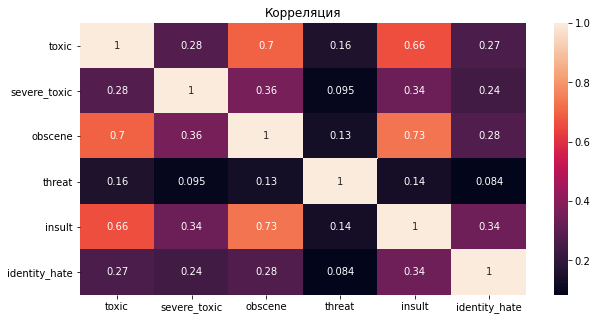

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=sample.corr(), 
            annot=True, ax=ax)
plt.title("Корреляция")
plt.show()

В целом здесь нет сильно удивляющих результатов, поскольку можно предположить, что один вид токсичности не обязательно повлечет за собой другой, но они также могут встречаться и совместно. Тем не менее видно, что оскорбления достаточно часто встречаются с обсценной лексикой – вероятнее всего, в этой лексике они и выражаются в этих случаях.

## 2 строка: Бейзлайн

*Бейзлайн модель из sklearn (векторайзер + модель) с отбором признаков (через l1 регуляризацию, на глаз через анализ важных параметров или через permutation importance)*

---







In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=50000, max_features=100000)

In [ ]:
X = tfidf.fit_transform(sample.normalized)
y = sample.toxic

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
%%time
lr = LogisticRegression(penalty='l1', \
                        solver='liblinear', \
                        C=100.0, \
                        tol=1e-6, 
                        max_iter=1000).fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

CPU times: user 1.56 s, sys: 1.95 ms, total: 1.56 s
Wall time: 1.57 s


In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, predicted_lr, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97      5036
     class 1       0.77      0.60      0.67       553

    accuracy                           0.94      5589
   macro avg       0.86      0.79      0.82      5589
weighted avg       0.94      0.94      0.94      5589



In [ ]:
#попробуем увеличить C
lr = LogisticRegression(penalty='l1', \
                        solver='liblinear', \
                        C=1000.0, \
                        tol=1e-6, 
                        max_iter=1000).fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, predicted_lr, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.97      0.97      5036
     class 1       0.73      0.63      0.68       553

    accuracy                           0.94      5589
   macro avg       0.85      0.80      0.82      5589
weighted avg       0.94      0.94      0.94      5589



Метрики отличаются совсем слабо. Скорее всего, увеличение C не даст существенного изменения результата.

In [ ]:
#попробуем уменьшить C
lr = LogisticRegression(penalty='l1', \
                        solver='liblinear', \
                        C=10.0, \
                        tol=1e-6, 
                        max_iter=1000).fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, predicted_lr, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97      5036
     class 1       0.81      0.59      0.68       553

    accuracy                           0.95      5589
   macro avg       0.88      0.79      0.82      5589
weighted avg       0.94      0.95      0.94      5589



In [ ]:
#попробуем еще уменьшить C
lr = LogisticRegression(penalty='l1', \
                        solver='liblinear', \
                        C=1.0, \
                        tol=1e-6, 
                        max_iter=1000).fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, predicted_lr, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.99      0.97      5036
     class 1       0.88      0.48      0.62       553

    accuracy                           0.94      5589
   macro avg       0.91      0.74      0.80      5589
weighted avg       0.94      0.94      0.93      5589



Если судить по f-мере и accuracy, то оптимальный результат дает C=10.0.

In [ ]:
#уменьшим число фич, иначе колаб будет крашиться
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=5000, max_features=5000)

In [ ]:
X = tfidf.fit_transform(sample.normalized)
y = sample.toxic

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
lr = LogisticRegression(penalty='l1', \
                        solver='liblinear', \
                        C=10.0, \
                        tol=1e-6, 
                        max_iter=1000).fit(X_train, y_train)

In [ ]:
%%time
perm = PermutationImportance(lr, random_state=42).fit(X_train.toarray(), y_train)
weights = eli5.formatters.as_dataframe.explain_weights_df(perm)

top_features = [int(i[1:]) for i in weights[weights.weight != 0].feature if 'BIAS' not in i]
X_train_perm = X_train.toarray()[:,top_features]
X_test_perm = X_test.toarray()[:,top_features]


CPU times: user 1h 17min 58s, sys: 24min 14s, total: 1h 42min 13s
Wall time: 51min 50s


In [ ]:
perm_model = LogisticRegression().fit(X_train_perm, y_train)
predicted_lr_perm = perm_model.predict(X_test_perm)

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predicted_lr_perm, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.94      1.00      0.97      5036
     class 1       0.94      0.41      0.57       553

    accuracy                           0.94      5589
   macro avg       0.94      0.70      0.77      5589
weighted avg       0.94      0.94      0.93      5589



In [ ]:
eli5.show_weights(perm_model, top=50)

Weight?,Feature
+9.118,x0
+6.725,x1
+6.454,x2
+5.425,x5
+5.368,x6
+5.324,x3
+5.127,x4
+4.929,x7
+4.128,x10
+4.076,x9


In [ ]:
eli5.sklearn.explain_weights.explain_linear_regressor_weights(perm_model, top=50)

Weight?,Feature
+9.118,x0
+6.725,x1
+6.454,x2
+5.425,x5
+5.368,x6
+5.324,x3
+5.127,x4
+4.929,x7
+4.128,x10
+4.076,x9


In [ ]:
perm_model.coef_

array([[ 9.11781305,  6.72487795,  6.45364178, ...,  0.64494776,
        -0.04081715, -0.04508193]])

## 3 строка: Кластеризация

*Использование кластеризационного алгоритма для разделение по токсичности (оценивание нужно сделать по специальным метрикам на кросс-валидации)*

---

In [ ]:
def clasterisation_metrics(model, X, y, labels, cv=5):
  v_score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='v_measure_score'))
  hm_score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='homogeneity_score'))
  c_score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='completeness_score'))
  ar_score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='adjusted_rand_score'))
  mi_score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='adjusted_mutual_info_score'))
  print(f'Cross-validation V-measure mean score: {v_score}')
  print(f'Cross-validation Homogeneity mean score: {hm_score}')
  print(f'Cross-validation Completeness mean score: {c_score}')
  print(f'Cross-validation Adjusted Rand Index mean score: {ar_score}')
  print(f'Cross-validation Mutual Information mean score: {mi_score}')
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

In [ ]:
def clasterisation(X, cluster_model):
  cluster_model.fit(X)
  labels = cluster_model.labels_
  return labels

In [ ]:
cluster_MBKMeans = MiniBatchKMeans(n_clusters=500, init_size=500, \
                                   verbose=2, max_iter=1000, batch_size=500, random_state=42, \
                                   max_no_improvement=200, reassignment_ratio=0.3)

In [ ]:
%%time
labels_MBKMeans = clasterisation(X, cluster_MBKMeans)

Init 1/3 with method: k-means++
Inertia for init 1/3: 271.294137
Init 2/3 with method: k-means++
Inertia for init 2/3: 273.522050
Init 3/3 with method: k-means++
Inertia for init 3/3: 278.237167
Minibatch iteration 1/45000: mean batch inertia: 0.723919, ewa inertia: 0.723919 
Minibatch iteration 2/45000: mean batch inertia: 0.732633, ewa inertia: 0.724309 
Minibatch iteration 3/45000: mean batch inertia: 0.680658, ewa inertia: 0.722356 
Minibatch iteration 4/45000: mean batch inertia: 0.644986, ewa inertia: 0.718895 
Minibatch iteration 5/45000: mean batch inertia: 0.680611, ewa inertia: 0.717183 
Minibatch iteration 6/45000: mean batch inertia: 0.652258, ewa inertia: 0.714279 
Minibatch iteration 7/45000: mean batch inertia: 0.616779, ewa inertia: 0.709918 
Minibatch iteration 8/45000: mean batch inertia: 0.617316, ewa inertia: 0.705775 
Minibatch iteration 9/45000: mean batch inertia: 0.614747, ewa inertia: 0.701704 
[MiniBatchKMeans] Reassigning 250 cluster centers.
Minibatch iterat

In [ ]:
clasterisation_metrics(cluster_MBKMeans, X, y, labels_MBKMeans)

Streaming output truncated to the last 5000 lines.
Minibatch iteration 86/36000: mean batch inertia: 0.565193, ewa inertia: 0.573827 
Minibatch iteration 87/36000: mean batch inertia: 0.568240, ewa inertia: 0.573515 
Minibatch iteration 88/36000: mean batch inertia: 0.572115, ewa inertia: 0.573436 
Minibatch iteration 89/36000: mean batch inertia: 0.548456, ewa inertia: 0.572040 
[MiniBatchKMeans] Reassigning 250 cluster centers.
Minibatch iteration 90/36000: mean batch inertia: 0.571071, ewa inertia: 0.571986 
Minibatch iteration 91/36000: mean batch inertia: 0.554531, ewa inertia: 0.571010 
Minibatch iteration 92/36000: mean batch inertia: 0.572694, ewa inertia: 0.571104 
Minibatch iteration 93/36000: mean batch inertia: 0.533482, ewa inertia: 0.569000 
Minibatch iteration 94/36000: mean batch inertia: 0.556376, ewa inertia: 0.568294 
Minibatch iteration 95/36000: mean batch inertia: 0.572490, ewa inertia: 0.568529 
Minibatch iteration 96/36000: mean batch inertia: 0.595954, ewa iner

**Cross-validation scores**

* Cross-validation V-measure mean score: 0.042408546827610485
* Cross-validation Homogeneity mean score: 0.37651671829298167
* Cross-validation Completeness mean score: 0.02246981730983784
* Cross-validation Adjusted Rand Index score: -6.764514362472907e-05
* Cross-validation Mutual Information score: 0.028507638059278605

**Other score** \
Silhouette Coefficient: 0.052

### Примеры кластеров

In [ ]:
sample['cluster'] = labels_MBKMeans

In [ ]:
#кластер с определенным ругательством 
sample[sample.cluster==438].head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normalized,cluster
128782,b0b8f1eaa83616fe,sex fucksex fucksex fucksex fucksex fucksex fu...,1,1,1,0,0,0,sex fucksex fucksex fucksex fucksex fucksex fu...,438
190231,7a67e7404e94b12c,== Reception == \n\n I think we should include...,1,0,0,0,1,0,reception == think include breast implant ridi...,438
193416,873a4de520afb78b,FUCK THIS I HAD MY SAYING BUT U RUINED IT BYE:),1,0,1,0,0,0,fuck say u ruin bye,438
150752,7182e88245e73fe7,You twats know fuck all about anything.,1,0,1,0,1,0,twats know fuck anything,438
28734,4c1b817ee7d2cb7d,Msg for Vandalisim? \n\nWhy am I getting this ...,1,0,1,0,0,0,msg vandalisim? get message wall? fuck,438
38463,66a9cd041f1e2d0c,"""YOU FAT FUCK\n\nYOU FAT FUCK\n\nYOU FAT FUCK\...",1,1,1,0,1,0,fat fuck fat fuck fat fuck fat fuck fat fuck f...,438
16741,2c261ffa88c0eed4,FUCK VUVUZELAS FUCK VUVUZELAS FUCK VUVUZELAS F...,1,0,1,0,0,0,fuck vuvuzelas fuck vuvuzelas fuck vuvuzelas f...,438
2490,06a132e6a70c8fb8,WHAT THE FUCK IS WRONG WITH YOU PEOPLE? STOP C...,1,1,1,0,0,0,fuck wrong people? stop critizing us!!! write ...,438
218919,ed1a8d833a9754fc,If you fuck with us again we will bash your fu...,1,0,1,1,0,0,fuck us bash fuck skull,438
203095,ad7504f00e70696b,fuck off u dush bag....,1,0,1,0,1,0,fuck u dush bag,438


In [ ]:
#кластер с обращениями и упоминаниями конкретных имен
sample[sample.cluster==19].head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normalized,cluster
2620,0700ee9d51b55d33,William S Saturn is a sockpuppet \n\nHey dickw...,1,0,1,0,1,0,"william saturn sockpuppet hey dickweed saturn,...",19
10813,1c96e8a4e320dfd4,sarah palin is an ass kissing mother fucking l...,1,1,1,0,1,1,sarah palin as kiss mother fuck loser melon ha...,19
90439,f2021581f1a60833,what's up asshole bitch,1,0,1,0,1,0,what's asshole bitch,19
143779,02a401b92814513b,The Best Remix for P.I.M.P. \n\n. . . . .I DON...,1,0,1,0,0,0,best remix p.i.m.p. . . . . .i dont kno u herd...,19
97389,090aad8ba220e273,"Nigga ya knoe I'm down, \n\nMayne I'm down if ...",1,0,1,0,1,0,"nigga ya knoe i'm down, mayne i'm ganna bust b...",19
96740,05719351ad26589b,fk u bitch \n\ni h8 u enit,1,0,1,0,1,0,fk u bitch h8 u enit,19
159588,001068b809feee6b,""" \n\n ==balance== \n This page has one senten...",0,0,0,0,0,0,==balance== page one sentence basic definition...,19
194303,8abbd8612744a4aa,.Even though I thought he was down for all the...,1,0,1,0,1,0,even though think bitch hoes. later realize fu...,19
92124,f64b7d5518c05c76,bitch \n\nfuck you b***h,1,1,1,0,1,0,bitch fuck b***h,19
210163,c9aaead840e0c7a2,GANDHI IS A BITCH!!!!,1,0,1,0,1,0,gandhi bitch,19


In [ ]:
#один из нетоксичных кластеров
sample[sample.cluster==32].head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normalized,cluster
57400,997db026afacc8b3,"Also, it is MY talk page, not YOURS. What sens...",0,0,0,0,0,0,"also, talk page, yours. sense make make three ...",32
201221,a62bf6a3f634836c,""" \n ::::There are several problems with a 95%...",0,0,0,0,0,0,::::there several problem 95% solution base ex...,32
150126,67165d6fdb695c2f,"""\nIt would be more accurate to describe the c...",0,0,0,0,0,0,would accurate describe change hyphen make wp ...,32
187924,710dc1106543779f,""" \n :Surely it makes more sense to use the se...",0,0,0,0,0,0,":surely make sense use search string `gnaa """"h...",32
81,0033b9d5ccd499fb,"""\n\nIs it scientific to attribute an event A,...",0,0,0,0,0,0,"scientific attribute event a, cause b, cause b...",32
11002,1d16bc5bbdcfa2ad,I put the Chart Singles in the order they came...,0,0,0,0,0,0,"put chart single order come out, make sense. r...",32
160510,03e88a45955b182c,""":::::Common sense is based on common knowledg...",0,0,0,0,0,0,common sense base common knowledge. common sen...,32
15031,27bbdff58c8416eb,"""\n\n Your block \n\nWhile I understood your b...",0,0,0,0,0,0,"block understand block admit violate wp:pa, co...",32
50599,874b91f456fba3b8,"""\n\n Okay, now I'm intrigued: Why do you even...",0,0,0,0,0,0,"okay, i'm intrigued: even bother """"contributin...",32
214824,dcae141a538fd685,:@Bill the Cat: You can't prove a negative. Do...,0,0,0,0,0,0,bill cat: can't prove negative. silly. accord ...,32


In [ ]:
#число кластеров
len(set(labels_MBKMeans))

482

## 4 строка: Нейронная модель (+ 5 строка: токенизация)

*Любая нейронная модель (минимум 5 слоев) с Dropout, Pooling и колбеками*


---


*Использование токенизации на символьные нграммы (не параметром analyzer=’char’, а вручную или готовым энструментов вроде youtokentome)*


---



In [ ]:
def model_picture_f1(model):
  print(model.history.history.keys())
  plt.plot(model.history.history['f1'])
  plt.plot(model.history.history['val_f1'])
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def model_picture_acc(model):
  print(model.history.history.keys())
  plt.plot(model.history.history['accuracy'])
  plt.plot(model.history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def model_picture_roc_auc(model):
  print(model.history.history.keys())
  plt.plot(model.history.history['roc_auc'])
  plt.plot(model.history.history['val_roc_auc'])
  plt.title('model roc_auc')
  plt.ylabel('roc_auc')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Функция для посчета ROC-кривой со [стэковерфлоу](https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras)

In [ ]:
def roc_auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
def sym_tokenize(text):
  text = text.lower()
  spaces = '\t\n\r\x0b\x0c'
  symbols = []
  for sym in text:
    if sym in spaces or sym == ' ':
      symbols.append(' ')
    else:
      symbols.append(sym)
      
  return symbols

In [ ]:
def make_vocab(texts):
  vocab = Counter()

  for text in texts:
      vocab.update(sym_tokenize(text))

  filtered_vocab = set()

  for sym in vocab:
    if vocab[sym] > 1:
        filtered_vocab.add(sym)
        
  return filtered_vocab

In [ ]:
def make_indices(vocab):
  sym2id = {'UNK':1, 'PAD':0}
  for sym in vocab:
      sym2id[sym] = len(sym2id)
  id2sym = {i:sym for sym, i in sym2id.items()}

  return sym2id, id2sym

In [ ]:
def text2ids(texts):
  X = []

  for text in texts:
      tokens = sym_tokenize(text)
      ids = [sym2id.get(token, 1) for token in tokens]
      X.append(ids)

  return X

In [ ]:
toxic_vocab = make_vocab(sample.normalized)

In [ ]:
sym2id, id2sym = make_indices(toxic_vocab)

In [ ]:
X = text2ids(sample.normalized.values)

In [ ]:
len(X)

22355

In [ ]:
len(y)

22355

In [ ]:
MAX_LEN = max(len(x) for x in X)

In [ ]:
MAX_LEN

5000

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])

In [ ]:
MEAN_LEN

134.0

In [ ]:
MAX_LEN = int(MEAN_LEN-5)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')

In [ ]:
y = sample.toxic.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=5, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='tanh', padding='same')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='tanh', padding='same')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='tanh', padding='same')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=2, activation='tanh', padding='same')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=2, activation='tanh', padding='same')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=2, activation='tanh', padding='same')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=2, activation='tanh', padding='same')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=2, activation='tanh', padding='same')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=2, activation='tanh', padding='same')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.5)(pool3)
convs.append(drop3)

concat = tf.keras.layers.Concatenate()(convs)
flatten = tf.keras.layers.Flatten()(concat)
dense = tf.keras.layers.Dense(64, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1, 'accuracy', roc_auc])


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 129)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 129, 50)      48300       input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_54 (Conv1D)              (None, 65, 64)       16064       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 65, 32)       8032        embedding_6[0][0]                
____________________________________________________________________________________________

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
         epochs=10,
        callbacks=[checkpoint, early_stop])

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 0.3565 - f1: 0.0047 - accuracy: 0.8896 - roc_auc: 0.6175
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to model.weights
43/43 [==============================] - 15s 346ms/step - loss: 0.3565 - f1: 0.0047 - accuracy: 0.8896 - roc_auc: 0.6175 - val_loss: 0.2925 - val_f1: 0.0000e+00 - val_accuracy: 0.9043 - val_roc_auc: 0.7362
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 0.2817 - f1: 0.0390 - accuracy: 0.9050 - roc_auc: 0.7474
Epoch 00002: val_f1 improved from 0.00000 to 0.22100, saving model to model.weights
43/43 [==============================] - 15s 338ms/step - loss: 0.2817 - f1: 0.0390 - accuracy: 0.9050 - roc_auc: 0.7474 - val_loss: 0.2600 - val_f1: 0.2210 - val_accuracy: 0.9123 - val_roc_auc: 0.8050
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 0.2678 - f1: 0.2024 - accuracy: 0.9108 - roc_auc: 0.7828
Epoch 00003: val_f1 improved from 0.22100 to 0.31123

dict_keys(['loss', 'f1', 'accuracy', 'roc_auc', 'val_loss', 'val_f1', 'val_accuracy', 'val_roc_auc'])


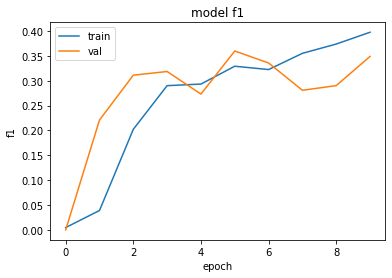

In [ ]:
model_picture_f1(model)

dict_keys(['loss', 'f1', 'accuracy', 'roc_auc', 'val_loss', 'val_f1', 'val_accuracy', 'val_roc_auc'])


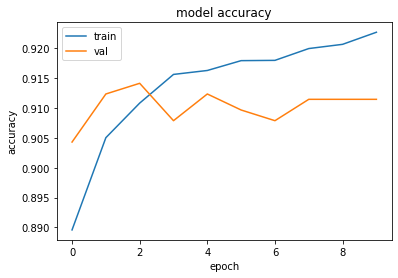

In [ ]:
model_picture_acc(model)

dict_keys(['loss', 'f1', 'accuracy', 'roc_auc', 'val_loss', 'val_f1', 'val_accuracy', 'val_roc_auc'])


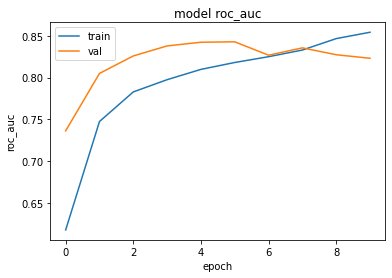

In [ ]:
model_picture_roc_auc(model)

In [ ]:
eval_model = model.evaluate(X_valid, y_valid, verbose=0)
print(f'Test loss: {eval_model[0]}, Test accuracy: {eval_model[1]}')

Test loss: 0.26224908232688904, Test accuracy: 0.28789111971855164


In [ ]:
preds = model.predict(X_valid)

In [ ]:
print(classification_report(y_valid, (preds.reshape(-1) > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1011
           1       0.60      0.23      0.34       107

    accuracy                           0.91      1118
   macro avg       0.76      0.61      0.64      1118
weighted avg       0.89      0.91      0.89      1118



In [ ]:
print(roc_auc_score(y_valid, (preds.reshape(-1) > 0.5).astype(int)))

0.6084149125969477


In [ ]:
def best_cnn():
  inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
  embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

  convs = []

  conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='tanh', padding='same')(embeddings)
  conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='tanh', padding='same')(conv1)
  conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='tanh', padding='same')(conv2)
  pool1 = tf.keras.layers.AveragePooling1D()(conv3)
  drop1 = tf.keras.layers.Dropout(0.2)(pool1)
  convs.append(drop1)

  conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=2, activation='tanh', padding='same')(embeddings)
  conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=2, activation='tanh', padding='same')(conv4)
  conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=2, activation='tanh', padding='same')(conv5)
  pool2 = tf.keras.layers.AveragePooling1D()(conv6)
  drop2 = tf.keras.layers.Dropout(0.2)(pool2)
  convs.append(drop2)

  conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=2, activation='tanh', padding='same')(embeddings)
  conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=2, activation='tanh', padding='same')(conv7)
  conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=2, activation='tanh', padding='same')(conv8)
  pool3 = tf.keras.layers.AveragePooling1D()(conv9)
  drop3 = tf.keras.layers.Dropout(0.2)(pool3)
  convs.append(drop3)

  concat = tf.keras.layers.Concatenate()(convs)
  flatten = tf.keras.layers.Flatten()(concat)
  dense = tf.keras.layers.Dense(64, activation='relu')(flatten)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model 


In [ ]:
clf = KerasClassifier(build_fn=best_cnn, epochs=10, batch_size=500, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
f_score = np.mean(cross_val_score(clf, X, y, cv=kfold, scoring='f1_macro'))
acc = np.mean(cross_val_score(clf, X, y, cv=kfold, scoring='accuracy'))
print(f'Cross-validation mean f-score: {f_score}')
print(f'Cross-validation accuracy mean score: {acc}')

Cross-validation mean f-score: 0.6426549844512188
Cross-validation accuracy mean score: 0.9070451189204116


In [ ]:
target_names = ['class 0', 'class 1']
clf.fit(X_train, y_train)
preds = (clf.predict(X_valid) > 0.5).astype(int)
print(classification_report(y_valid, preds, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.92      0.98      0.95      1008
     class 1       0.58      0.25      0.35       110

    accuracy                           0.91      1118
   macro avg       0.75      0.62      0.65      1118
weighted avg       0.89      0.91      0.89      1118

